# Mask generating algorithm

In [1]:
import os
import json 
import logging

logging.basicConfig(
    filename='log/app.log',            # Specify the log file name
    level=logging.DEBUG,           # Set the log level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s'  # Set the log format
)

# Load the environment configuration JSON data
json_path = 'env_config.json'
with open(json_path, 'r') as file:
    env_config = json.load(file)

hf_home = env_config['HF_HOME']
# Set the HF_HOME environment variable
os.environ['HF_HOME'] = hf_home
# Set the access token to huggingface hub
access_token = env_config['access_token']
os.environ['HUGGINGFACE_HUB_TOKEN'] = access_token

In [2]:
import torch 
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from PIL import Image
import requests
import matplotlib.pyplot as plt

import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

from accelerate import Accelerator

import logging
import sys

from maskgen.utils.vit_mod import ModViTForImageClassification

accelerator = Accelerator()
device = accelerator.device
# device = 'cuda:3'

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Model

In [3]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

original_model = ViTForImageClassification.from_pretrained(pretrained_name)
state_dict = original_model.state_dict()
del original_model # remove the model to free up memory
# change to use_mask_token = True
pred_model = ModViTForImageClassification(config)
# load back the parameters from state_dict
# 为新的模型实例添加 mask_token 权重
if 'vit.embeddings.mask_token' not in state_dict:
    state_dict['vit.embeddings.mask_token'] = pred_model.vit.embeddings.mask_token

pred_model.load_state_dict(state_dict)

pred_model.to(device)
# set to eval mode
pred_model.eval()
print()

/afs/crc.nd.edu/user/d/dpan/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


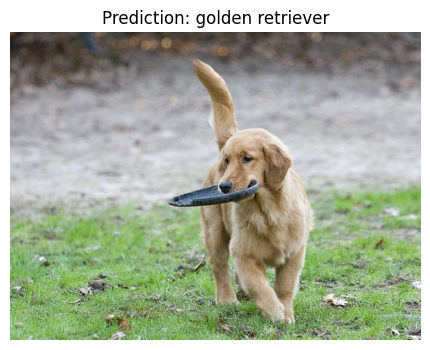

In [4]:
with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = pred_model.config.id2label[predicted_class_idx]

plt.figure(figsize=(6, 4))  # 设置图像显示的大小
plt.imshow(image)
plt.axis('off')
plt.title(f'Prediction: {predicted_class}')
plt.show()

# 创建peft model 

In [5]:
from peft import LoraConfig, get_peft_model
# We use the same foundation model
exp_base_model = ViTModel.from_pretrained(pretrained_name)

# convert to peft model and ready to use LoRA 
# 手动列出所有层的目标模块

target_modules = []
num_layers = 12  # BERT-base 有 12 层
for i in range(num_layers):
    target_modules.extend([
        f"encoder.layer.{i}.attention.attention.query",
        f"encoder.layer.{i}.attention.attention.key",
        f"encoder.layer.{i}.attention.attention.value",
        f"encoder.layer.{i}.attention.output.dense",
        f"encoder.layer.{i}.intermediate.dense",
        f"encoder.layer.{i}.output.dense"
    ])

lora_config = LoraConfig(
    r=4,  # 低秩矩阵的秩
    lora_alpha=32,  # LoRA 的缩放因子
    target_modules= target_modules,  # 目标模块
    lora_dropout=0.1  # Dropout 概率
)
exp_base_model = get_peft_model(exp_base_model, lora_config)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load MaskGeneratingModel

In [26]:
from maskgen.vision_models.vision_maskgen_clip import MaskGeneratingModel

mask_gen_model = MaskGeneratingModel(base_model=exp_base_model, hidden_size=config.hidden_size, num_classes=config.num_labels)
mask_gen_model.to(device)
print()

mask_gen_model.load_state_dict(torch.load("trained/vision_clip_20240815-230804.pt"))


<All keys matched successfully>

## Show Example

# Demo trained examples

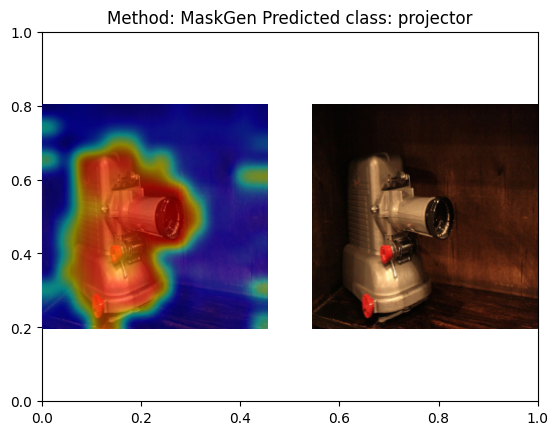

In [36]:
from maskgen.utils.img_utils import plot_overlap_np

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
# url = "http://farm9.staticflickr.com/8490/8179481059_41be7bf062_z.jpg"
# url = "http://farm1.staticflickr.com/76/197438957_b20800e7cf_z.jpg"
# url = "http://farm3.staticflickr.com/2284/5730266001_7d051b01b7_z.jpg"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01491361_tiger_shark.JPEG?raw=true"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n03000684_chain_saw.JPEG?raw=true"
url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n04009552_projector.JPEG?raw=true"
image = Image.open(requests.get(url, stream=True).raw)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = pred_model(img).logits.argmax(-1).item()

label = torch.tensor([predicted_class_idx]).to(device)

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
heatmap = mask_gen_model.attribute_img(img, label, image_size=224, patch_size=16)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

In [37]:
print("heatmap_max", heatmap.max())
print("heatmap_min", heatmap.min())
print("heatmap_mean", heatmap.mean())

heatmap_max 0.86151046
heatmap_min 0.14194226
heatmap_mean 0.41929322


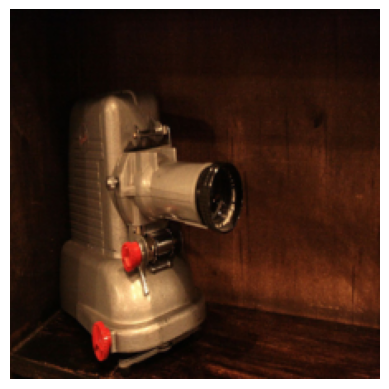

In [38]:
plt.axis('off')
plt.imshow(img_int)

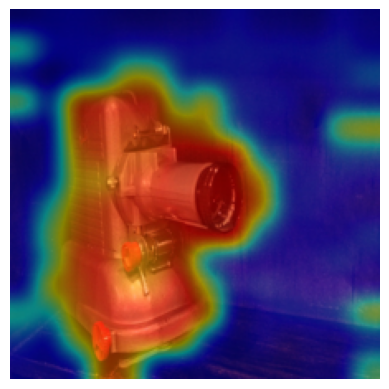

In [39]:
from maskgen.utils.img_utils import plot_overlap_np, plot_overlap

plot_overlap(img_int, heatmap_img)

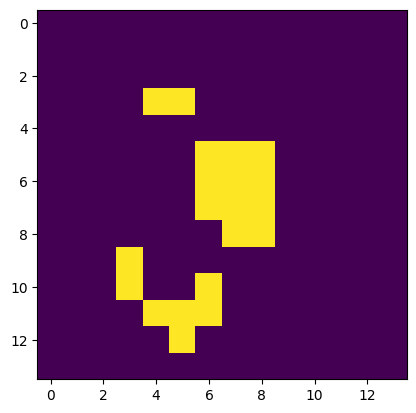

In [40]:
# test_mask = obtain_masks_on_topk(heatmap, 20, 'ins')
plt.imshow((heatmap > np.quantile(heatmap, 0.9)))
# plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
# plt.show()

In [12]:
# from maskgen.utils import idx_to_selector

# def get_sampled_heatmap(img, sim, pseudo_label, n_samples=10):
#     predicted_class_selector = idx_to_selector(pseudo_label, 1000)
#     sampled_mask_list = []
#     for _ in range(n_samples):
#         sampled_mask, sampled_mask_prob, _, _ = mask_gen_model.sample_one_step(img, sim, predicted_class_selector=predicted_class_selector)
#         sampled_mask_list.append(sampled_mask * sampled_mask_prob)

#     heatmap = torch.stack(sampled_mask_list).mean(0).reshape(-1, 16, 16)
#     return heatmap

# n_samples = 100
# with torch.no_grad():
#     inputs = processor(images=image, return_tensors="pt")
#     inputs.to(device)
#     img = inputs['pixel_values']
#     img = img.to(device)
#     pseudo_label = pred_model(img).logits.argmax(-1)
#     predicted_class_idx = pseudo_label.item()
    
#     sim = mask_gen_model(img)['sim']

# plt.title(f"MaskGen_G Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
# # heatmap = mask_gen_model.attribute_img(img, image_size=224, patch_size=14)
# # heatmap_list = [mask_gen_model.generate_mask(sim) for _ in range(n_samples)]

# # heatmap = torch.stack(heatmap_list).mean(0).reshape(-1, 16, 16)
# heatmap = get_sampled_heatmap(img, sim, pseudo_label, n_samples=n_samples)
# heatmap = heatmap.squeeze(0).detach().cpu().numpy()
# img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

# img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

# Batch Evaluation

In [13]:
from torch.utils.data import DataLoader

def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, _, test_ds = load_data()

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

test_ds.set_transform(preprocess)
train_ds.set_transform(preprocess)

# batch size is limited to 2, because n_steps could could huge memory consumption
batch_size = 1000
test_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
# test_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

Repo card metadata block was not found. Setting CardData to empty.


In [14]:
from maskgen.evaluation import EvalGame
from tqdm import tqdm

# n_samples = 100

# random_mask
root_path = 'results/maskgen-vit'
topk = 10

eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)

def save_heatmap(heatmap, batch_size, idx, root_path):
    # convert to numpy
    heatmap = heatmap.detach().cpu().numpy() # [N, 1, 14, 14]
    tail_index = batch_size * (idx + 1)
    file_name = os.path.join(root_path, f"heatmap-{tail_index}")
    np.save(file_name, heatmap)
    
    return 0


# def get_sampled_heatmap(img, sim, pseudo_label, n_samples=10):
#     predicted_class_selector = idx_to_selector(pseudo_label, 1000)
#     sampled_mask_list = []
#     for _ in range(n_samples):
#         sampled_mask, sampled_mask_prob, _, _ = mask_gen_model.sample_one_step(img, sim, predicted_class_selector=predicted_class_selector)
#         sampled_mask_list.append(sampled_mask * sampled_mask_prob)

#     heatmap = torch.stack(sampled_mask_list).mean(0).reshape(-1, 16, 16)
#     return heatmap
    

ins_score_list = []
del_score_list = []
heatmap_list = []


for idx, data in tqdm(enumerate(test_dataloader)):
    pixel_values = data['pixel_values'].to(device)
    with torch.no_grad():
        pseudo_label = pred_model(pixel_values).logits.argmax(-1).view(-1)

    # sum up all 3 RGB channels for heatmap
    attr = mask_gen_model.attribute_img(pixel_values, pseudo_label, image_size=224, patch_size=16) # [1,14,14]
    # sim = mask_gen_model(pixel_values)['sim']
    # attr = get_sampled_heatmap(pixel_values, sim, pseudo_label, n_samples=n_samples)


    # heatmap = attr.squeeze(1) # [1, 14, 14]
    heatmap = attr # [1, 14, 14]
    # heatmap = heatmap.squeeze(0).detach().cpu().numpy()
    heatmap_list.append(heatmap)
    if (idx + 1) * batch_size % 100 == 0:
        heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 14, 14)
        save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)
        heatmap_list = []

    with torch.no_grad():
        input_img = pixel_values
        ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
        del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

        # append to list
        ins_score_list.append(ins_score)
        del_score_list.append(del_score)
    
    # if idx >= 10:
    #     break

if len(heatmap_list) > 0:
    heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 224, 224)
    save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)

# heatmap = heatmap_list

5it [01:19, 15.92s/it]


In [15]:
# plt.imshow(attr[1].detach().cpu().numpy())

In [16]:
ins_score = torch.cat(ins_score_list, dim=0)
del_score = torch.cat(del_score_list, dim=0)

print(ins_score.mean())
print(del_score.mean())
# heatmap = heatmap.squeeze(0).detach().cpu().numpy()
# img = input_img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

# img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)
# tensor(0.6749, device='cuda:0')
# tensor(0.0431, device='cuda:0')

tensor(0.1578, device='cuda:0')
tensor(0.7219, device='cuda:0')


Predicted class: Christmas stocking


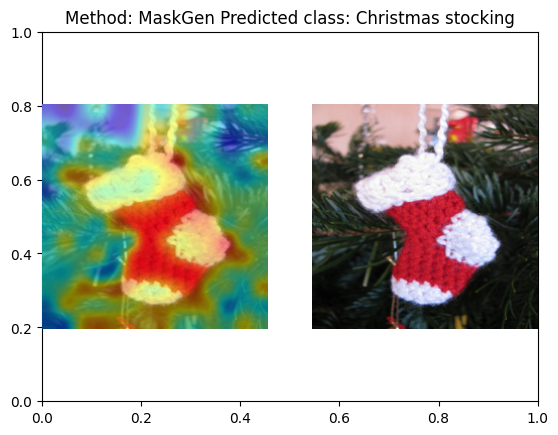

ins_score: tensor(0.0220, device='cuda:0')
del_score: tensor(0.9964, device='cuda:0')


In [17]:
from maskgen.utils.img_utils import plot_overlap_np

idx = 24

predicted_class_idx = pseudo_label[idx].item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

hm = heatmap[idx].detach().cpu().numpy()
img = input_img[idx].detach().cpu().numpy().transpose(1, 2, 0)

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
plt.annotate(f"ins_score: {ins_score_list[-1][idx]:.4f}", (0, 10))
plt.annotate(f"del_score: {del_score_list[-1][idx]:.4f}", (0, 20))

img_int, heatmap_img = plot_overlap_np(img, hm, mean, std)

print("ins_score:", ins_score_list[-1][idx])
print("del_score:", del_score_list[-1][idx])

In [18]:
heatmap[0]

tensor([[0.4374, 0.5269, 0.5376, 0.5184, 0.5218, 0.5288, 0.5388, 0.5178, 0.5186,
         0.5399, 0.5477, 0.5912, 0.4506, 0.4158],
        [0.4158, 0.5441, 0.5751, 0.5301, 0.5168, 0.5275, 0.4984, 0.4682, 0.5286,
         0.5276, 0.5361, 0.5656, 0.4994, 0.4098],
        [0.4274, 0.5280, 0.5199, 0.5280, 0.4940, 0.5043, 0.4964, 0.5054, 0.5043,
         0.5653, 0.5172, 0.6073, 0.5644, 0.3852],
        [0.4574, 0.5547, 0.5291, 0.5265, 0.5339, 0.5418, 0.5217, 0.5340, 0.5043,
         0.4978, 0.5345, 0.5054, 0.5409, 0.3919],
        [0.4708, 0.4935, 0.4657, 0.4756, 0.4764, 0.4995, 0.5048, 0.4867, 0.4721,
         0.4867, 0.4895, 0.4927, 0.4894, 0.4671],
        [0.4739, 0.4752, 0.4669, 0.4709, 0.4667, 0.5164, 0.5063, 0.5387, 0.4962,
         0.4833, 0.4931, 0.5047, 0.5026, 0.4974],
        [0.4720, 0.4599, 0.4784, 0.4852, 0.5129, 0.4774, 0.4843, 0.6241, 0.5671,
         0.4861, 0.5699, 0.5720, 0.5085, 0.5643],
        [0.4462, 0.4918, 0.4942, 0.4847, 0.4898, 0.5079, 0.5242, 0.5366, 0.5090,
  

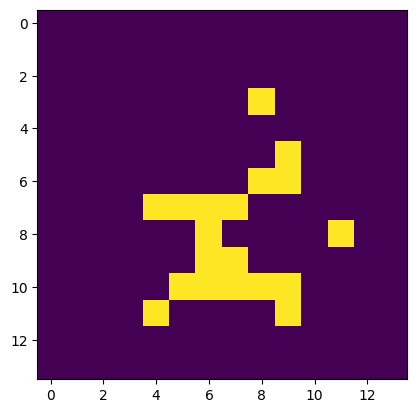

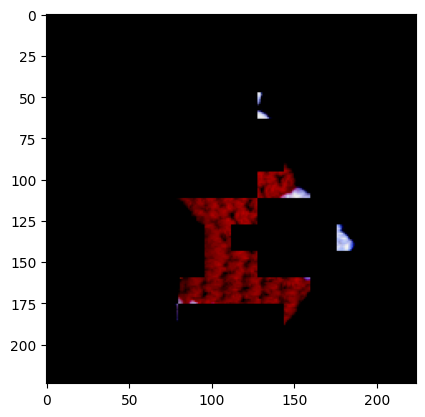

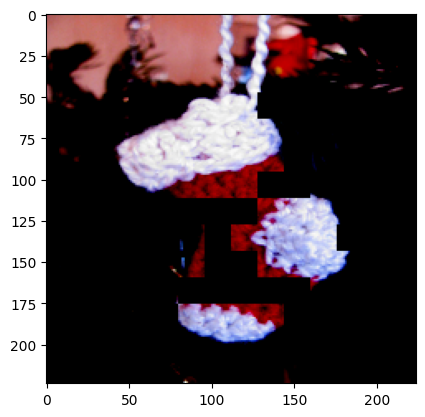

In [19]:
from maskgen.evaluation import obtain_masks_on_topk, obtain_masked_input_on_topk

test_img = input_img[idx:idx+1]
test_heatmap = heatmap[idx:idx+1]

mode = 'ins'
test_mask = obtain_masks_on_topk(test_heatmap, topk, mode)
test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode)
test_masked_img2 = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode='del')

# plt.imshow((heatmap[idx] > torch.quantile(heatmap[idx], 0.8)).float().cpu().numpy())
plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
plt.show()
plt.imshow(test_masked_img[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()
plt.imshow(test_masked_img2[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

In [20]:
from maskgen.evaluation import EvalGame, obtain_masks_on_topk, obtain_masked_input_on_topk
test_img = input_img[idx:idx+1]
test_heatmap = heatmap[idx:idx+1]
# eval_game.get_deletion_at_topk(test_img, test_heatmap, topk)
test_mask = obtain_masks_on_topk(test_heatmap, topk, mode='del')
test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk)
 # [N, 1, H_a, W_a]
resized_mask = F.interpolate(test_mask.unsqueeze(1), size=test_img.shape[-2:], mode='nearest')

test_predicted_class_idx = pred_model(test_masked_img).logits.argmax(-1)
print("Predicted class:", pred_model.config.id2label[test_predicted_class_idx.item()])

# probs = F.softmax(pred_model(test_masked_img).logits, dim=-1)
# print(eval_game.get_score_at_topk(test_img, test_heatmap, 20, mode='del'))

test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode='del')
probs = F.softmax(pred_model(test_masked_img).logits, dim=-1)
print(probs[:,439])


test_masked_img = obtain_masked_input_on_topk(test_img, test_mask, topk)


pseudo_label = self.model(x).argmax(-1) # [1, 1]
probs = torch.softmax(self.model(masked_input), dim=-1) # [N, 1000]

selector = idx_to_selector(pseudo_label, self.output_dim) # [N, 1000]
probs = (probs * selector).sum(-1) # [N,]
return probs # [N,]



plt.imshow(test_masked_img[0].detach().cpu().numpy().transpose(1, 2, 0))
# plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
# plt.imshow((test_masked_img * resized_mask)[0].detach().cpu().numpy().transpose(1, 2, 0))

NameError: name 'F' is not defined

In [ ]:
# from evaluation import EvalGame
# import os 
# import re
# from tqdm import tqdm


# root_path = 'results/mask-vit'
# model = lambda x: pred_model(pixel_values=x).logits
# eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)
# topk = 50

# def extract_number(filename):
#     """
#     Extract the first occurance of countinuous numbers in a file name
#     """
#     match = re.search(r'\d+', filename)
#     if match:
#         return int(match.group(0))
#     return 0

# def get_ordered_filename_list(root_path):
#     file_path_list = []
#     for filename in os.listdir(root_path):
#         if filename.endswith('.npy'):
#             file_path = os.path.join(root_path, filename)
#             file_path_list.append(file_path)
#     file_path_list = sorted(file_path_list, key=extract_number)
#     return file_path_list


# def load_heatmap(root_path):
#     file_path_list = get_ordered_filename_list(root_path)
#     for filename in file_path_list:
#        yield np.load(filename)


# ins_score_list = []
# del_score_list = []

# heatmap_generator = load_heatmap(root_path)
# test_dataloader_iterator = iter(test_dataloader)
# for idx, data in tqdm(enumerate(heatmap_generator)):
#     heatmap = torch.tensor(data, device=device)

#     with torch.no_grad():
#         # Average pooling to convert to 14*14 heatmap
#         heatmap = F.avg_pool2d(heatmap, kernel_size=16, stride=16)
#         input_img = next(test_dataloader_iterator)['pixel_values'].to(device)
#         ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
#         del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

#         # append to list
#         ins_score_list.append(ins_score)
#         del_score_list.append(del_score)